In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DCRNN data prep

In [ ]:
def dijkstra(matrix,m,n,k):
    cost=[[0 for x in range(m)] for x in range(1)]
    offsets = []
    offsets.append(k)
    elepos=0
    for j in range(m):
        cost[0][j]=matrix[k][j]
    mini=999
    for x in range (m-1):
        mini=999
        for j in range (m):
            if cost[0][j]<=mini and j not in offsets:
                    mini=cost[0][j]
                    elepos=j
        offsets.append(elepos)
        for j in range (m):
            if cost[0][j] >cost[0][elepos]+matrix[elepos][j]:
                cost[0][j]=cost[0][elepos]+matrix[elepos][j]
    #print("The cost to various vertices in order:",cost[0])
    return cost[0]

def get_matrix(distance_df, sensor_ids, normalized_k=0.1):

    num_sensors = len(sensor_ids)
    dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
    dist_mx[:] = np.inf

    sensor_id_to_ind = {}
    for i, sensor_id in enumerate(sensor_ids):
        sensor_id_to_ind[sensor_id] = i

    # Fills cells in the matrix with distances.
    for row in distance_df.values:
        if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
            continue
        dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = 1#row[2]

    return sensor_ids, sensor_id_to_ind, dist_mx

def get_adjacency_matrix(distance_df, sensor_ids, normalized_k=0.01):

    num_sensors = len(sensor_ids)
    dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
    #dist_mx[:] = np.inf

    sensor_id_to_ind = {}
    for i, sensor_id in enumerate(sensor_ids):
        sensor_id_to_ind[sensor_id] = i

    # Fills cells in the matrix with distances.
    for row in distance_df.values:
        if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
            continue
        dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = row[2]


    distances = dist_mx[~np.isinf(dist_mx)].flatten()
    
    std = distances.std()
    print(std)
    adj_mx = np.exp(-np.square(dist_mx / std))
    adj_mx[adj_mx < normalized_k] = 0

    return sensor_ids, sensor_id_to_ind, dist_mx #adj_mx  #dist_mx

In [ ]:
df = pd.read_csv('data/2018_1hourdata.csv')
node_list = []
for i in df.columns[1:]:
    li = i.rsplit('_', 1)
    node_list.append(li[0])
node_list2 = []
node_list3 = []
node_list4 = []
node_list5 = []
for i in node_list:
    li = i.rsplit('_', 1)
    node_list2.append(li)    
    node_list3.append(li[0])
    node_list4.append(li[1])
    node_list5.append(li[1])
node_list3 =  list(set(node_list3))
node_list4 =  list(set(node_list4))
total_node = list(set().union(node_list3,node_list4))

dict_ = {}
for idx, i in enumerate(total_node):
    df_temp = df.filter(regex=(i + "_"))    
    dict_[i] = int(df_temp.shape[1]/2) 
final_node_list = sorted(dict_, key=dict_.get, reverse=True)

sensor_ids = final_node_list
num_sensors = len(sensor_ids)

distance_df = pd.read_csv('data/distance_esl.csv', dtype={'from': 'str', 'to': 'str'})

_, sensor_id_to_ind, dist_mx = get_matrix(distance_df, sensor_ids)
network_dist = np.zeros((num_sensors, num_sensors), dtype=np.float32)
network_dist[:] = 0


results_list = []
for i in range(num_sensors):
    network_dist[i,:] = dijkstra(dist_mx,num_sensors,num_sensors,i)
    for j in range(num_sensors):
        dist = network_dist[i, j]
        if i == j:
            dist =  0#np.inf
            results_list.append([sensor_ids[i], sensor_ids[j], dist])
        elif np.isinf(dist):
            pass
        else:
            results_list.append([sensor_ids[i], sensor_ids[j], dist])

df_dist = pd.DataFrame(results_list)
df_dist.columns = ['from', 'to', 'distance']
df_dist.to_csv('data/network_distances.csv', index=False)

distance_df = pd.read_csv('data/network_distances.csv', dtype={'from': 'str', 'to': 'str'})
_, sensor_id_to_ind, adj_mx = get_adjacency_matrix(distance_df, sensor_ids)

with open('DCRNN/data/adj_mat.pkl', 'wb') as f:
    pickle.dump([sensor_ids, sensor_id_to_ind, adj_mx], f, protocol=2)
    
df = pd.read_csv('data/2018_1hourdata.csv')
date = pd.date_range(start='01/01/2018', end='01/02/2019', freq='1h')
date = date[8:-17]


for i in range(0,7):
    zero_data = np.zeros(shape=(df.shape[0],len(final_node_list)))
    df_new = pd.DataFrame(zero_data, columns=final_node_list)
    df_new = pd.DataFrame()
    column_names = []
    for idx2, j in enumerate(final_node_list):
        in_nodes = df.filter(regex=('_' + j + '_.*in$'))#.head(n=4)
        out_nodes = df.filter(regex=('^'+ j + '_.*out$'))#.head(n=4)
        result = pd.concat([in_nodes, out_nodes], axis=1, sort=False)
        if result.shape[1] -1 >= i:
            df_new[j] = result.iloc[:,i].reset_index(drop=True)
            column_names.append(result.columns[i])
        else:
            d = dict.fromkeys([j], 0)
            df_new = df_new.assign(**d)            
            column_names.append('nodata'+ str(idx2))
    df_new.index = date
    df_new.columns = column_names

    df_new.to_hdf('DCRNN/data/' + 'ts_%s.h5'%i, key='df', mode='w')


# DCRNN Results

In [ ]:
def MAPE(y_true, y_pred):
    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape

In [ ]:
lag = 24

cols = ['sites'] + list(map(str, list(range(1,lag + 1))))
df_mae = pd.DataFrame(columns=cols)
df_rmse = pd.DataFrame(columns=cols)
df_mse = pd.DataFrame(columns=cols)
df_r2 = pd.DataFrame(columns=cols)
df_mape = pd.DataFrame(columns=cols)

for num in range(0,7):    
    df_ref = pd.read_hdf('DCRNN/data/results/dcrnn_prediction_%s_h0.h5'%str(num))
    for idx, site in enumerate(df_ref.columns):
        if site[0:6] != 'nodata':    
            mae_list = []; rmse_list = []; mse_list = []; r2_list = []; mape_list = []
            df_obs = pd.read_hdf('esnet/data/results/ts_test_%s_h0.h5'%(str(num)))
            for hor in range(lag):
                df_pred = pd.read_hdf('DCRNN/data/results/dcrnn_prediction_%s_h%s.h5'%(str(num),str(hor)))
                

                yobs = df_obs.iloc[:,idx] 
                ypred = df_pred.iloc[:,idx]  
                mae_list.append(mean_absolute_error(yobs, ypred))
                rmse_list.append(np.sqrt(mean_squared_error(yobs, ypred)))
                mse_list.append(mean_squared_error(yobs, ypred))
                r2_list.append(r2_score(yobs, ypred))
                mape_list.append(MAPE(yobs, ypred))
            mae_list = [site] + mae_list
            rmse_list = [site] + rmse_list
            mse_list = [site] + mse_list
            r2_list = [site] + r2_list
            mape_list = [site] + mape_list
            df_mae = df_mae.append(dict( zip( cols, mae_list)), ignore_index=True)
            df_rmse = df_rmse.append(dict( zip( cols, rmse_list)), ignore_index=True)
            df_mse = df_mse.append(dict( zip( cols, mse_list)), ignore_index=True)
            df_r2 = df_r2.append(dict( zip( cols, r2_list)), ignore_index=True)
            df_mape = df_mape.append(dict( zip( cols, mape_list)), ignore_index=True)

In [ ]:
folder = 'Results/Results_DCRNN_full'
if not os.path.exists(folder):
    os.makedirs(folder)   
df_mae.to_csv(folder + '/MAE_DCRNN.csv')    
df_rmse.to_csv(folder + '/RMSE_DCRNN.csv')   
df_mse.to_csv(folder + '/MSE_DCRNN.csv')  
df_r2.to_csv(folder + '/R2_DCRNN.csv') 
df_mape.to_csv(folder + '/MAPE_DCRNN.csv')    
 

# D-DCRNN results

In [ ]:
df = pd.read_csv('data/2018_1hourdata.csv')

df['Time'] = pd.to_datetime(df['Time'])  
mask = (df['Time'] >= '2018-01-01 00:00:00') & (df['Time'] <= '2018-09-30 23:00:00') # Train
#mask = (df['Time'] >= '2018-10-01 00:00:00') & (df['Time'] <= '2018-10-31 23:00:00') # Val
#mask = (df['Time'] >= '2018-11-01 00:00:00') & (df['Time'] <= '2018-12-31 23:00:00') # Test
df_m1 = df.loc[mask] 
df_train = df_m1.set_index('Time')


lag = 24

cols = ['sites'] + list(map(str, list(range(1,lag + 1))))
df_mae = pd.DataFrame(columns=cols)
df_rmse = pd.DataFrame(columns=cols)
df_mse = pd.DataFrame(columns=cols)
df_r2 = pd.DataFrame(columns=cols)
df_mape = pd.DataFrame(columns=cols)


df_obs = pd.read_hdf('D_DCRNN/data/DDCRNN/test.h5').reset_index(drop=True)
for i in range(0,df_obs.shape[1]):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df.iloc[:,i].values.reshape(-1, 1))
    #df_test.iloc[:,i] = scaler.transform(df_test.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]
    df_obs.iloc[:,i] = scaler.inverse_transform(df_obs.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]


hist = 29; hori = 24
tail = df_obs.shape[0] - hist
head = tail - hori

#df_obs = df_obs[sites]
df_obs = df_obs.tail(n=tail).reset_index(drop=True)
df_obs = df_obs.head(n=head) #(n=1417)

for idx, site in enumerate(df_obs.columns):   
    mae_list = []; rmse_list = []; mse_list = []; r2_list = []; mape_list = []
    for hor in range(lag):
        df_pred = pd.read_hdf('D_DCRNN/data/results_30_24_full/ddcrnn_h%d.h5'%hor).reset_index(drop=True)
        df_pred = df_pred.fillna(0)
        df_pred.columns = df_obs.columns
        
        for i in range(0,df_obs.shape[1]):
            scaler = MinMaxScaler(feature_range=(0, 1)).fit(df.iloc[:,i].values.reshape(-1, 1))
            #df_test.iloc[:,i] = scaler.transform(df_test.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]
            df_pred.iloc[:,i] = scaler.inverse_transform(df_pred.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]


        yobs = df_obs.iloc[:,idx] 
        ypred = df_pred.iloc[:,idx]  
        mae_list.append(mean_absolute_error(yobs, ypred))
        rmse_list.append(np.sqrt(mean_squared_error(yobs, ypred)))
        mse_list.append(mean_squared_error(yobs, ypred))
        r2_list.append(r2_score(yobs, ypred))
        mape_list.append(MAPE(yobs, ypred))
    mae_list = [site] + mae_list
    rmse_list = [site] + rmse_list
    mse_list = [site] + mse_list
    r2_list = [site] + r2_list
    mape_list = [site] + mape_list
    df_mae = df_mae.append(dict( zip( cols, mae_list)), ignore_index=True)
    df_rmse = df_rmse.append(dict( zip( cols, rmse_list)), ignore_index=True)
    df_mse = df_mse.append(dict( zip( cols, mse_list)), ignore_index=True)
    df_r2 = df_r2.append(dict( zip( cols, r2_list)), ignore_index=True)
    df_mape = df_mape.append(dict( zip( cols, mape_list)), ignore_index=True)

In [ ]:
folder = 'Results/Results_DDCRNN_30_24_full'
if not os.path.exists(folder):
    os.makedirs(folder)   
df_mae.to_csv(folder + '/MAE_DCRNN.csv')    
df_rmse.to_csv(folder + '/RMSE_DCRNN.csv')   
df_mse.to_csv(folder + '/MSE_DCRNN.csv')  
df_r2.to_csv(folder + '/R2_DCRNN.csv') 
df_mape.to_csv(folder + '/MAPE_DCRNN.csv')    

# Plot

(-1.0, 1.0)

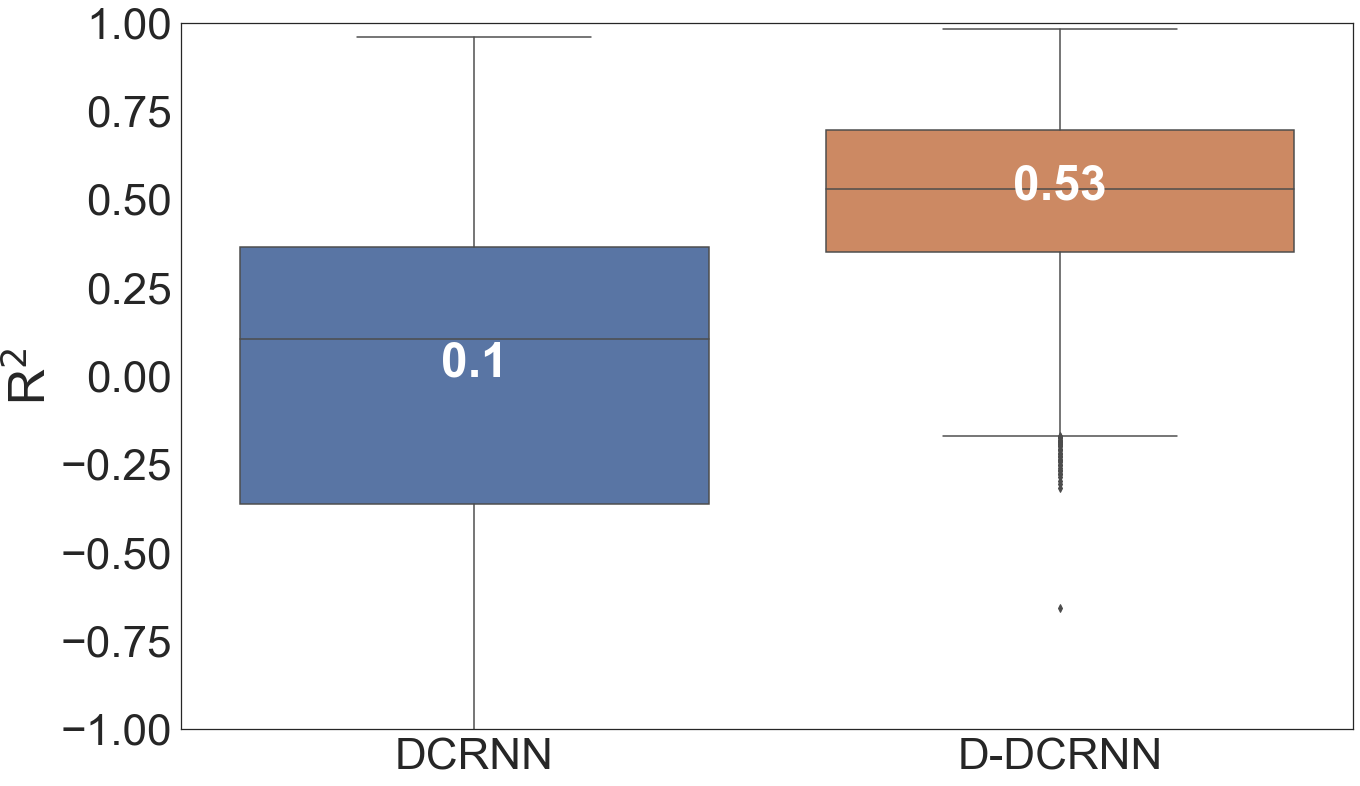

In [8]:
df_boot = pd.read_csv('Results/Results_DCRNN_full/R2_DCRNN.csv')
df_DDCRNN = pd.read_csv('Results/Results_DDCRNN_30_24_full/R2_DCRNN.csv')

df_DDCRNN = df_DDCRNN.set_index('sites')
df_boot = df_boot.set_index('sites')


df_new = pd.DataFrame()

df_new['DCRNN'] = df_boot.values.flatten()
df_new['D-DCRNN'] = df_DDCRNN.values.flatten() 

mL1 = []
mL1.append(np.round(df_new['DCRNN'].median(), decimals=2))
mL1.append(np.round(df_new['D-DCRNN'].median(), decimals=2))

sns.set(rc={'figure.figsize':(21,13)})
sns.set(font_scale = 4, style="white")
testPlot = sns.boxplot(data=df_new)

top = 0.0 #m1[ind+1]+1
for tick in range(len(mL1)):
    if tick == 1:
        top = .5
    
    testPlot.text(tick, top, mL1[tick],  horizontalalignment='center',  color='w', weight='semibold')


#testPlot.set_xlabel('Forecasting strategies', fontsize=50)  
testPlot.set_ylabel('R$^2$', fontsize=50)  
testPlot.set_ylim(-1,1)

#plt.savefig('/Users/tanwimallick/Desktop/esnet_plots/dcrnnVSddcrnnfull.png')

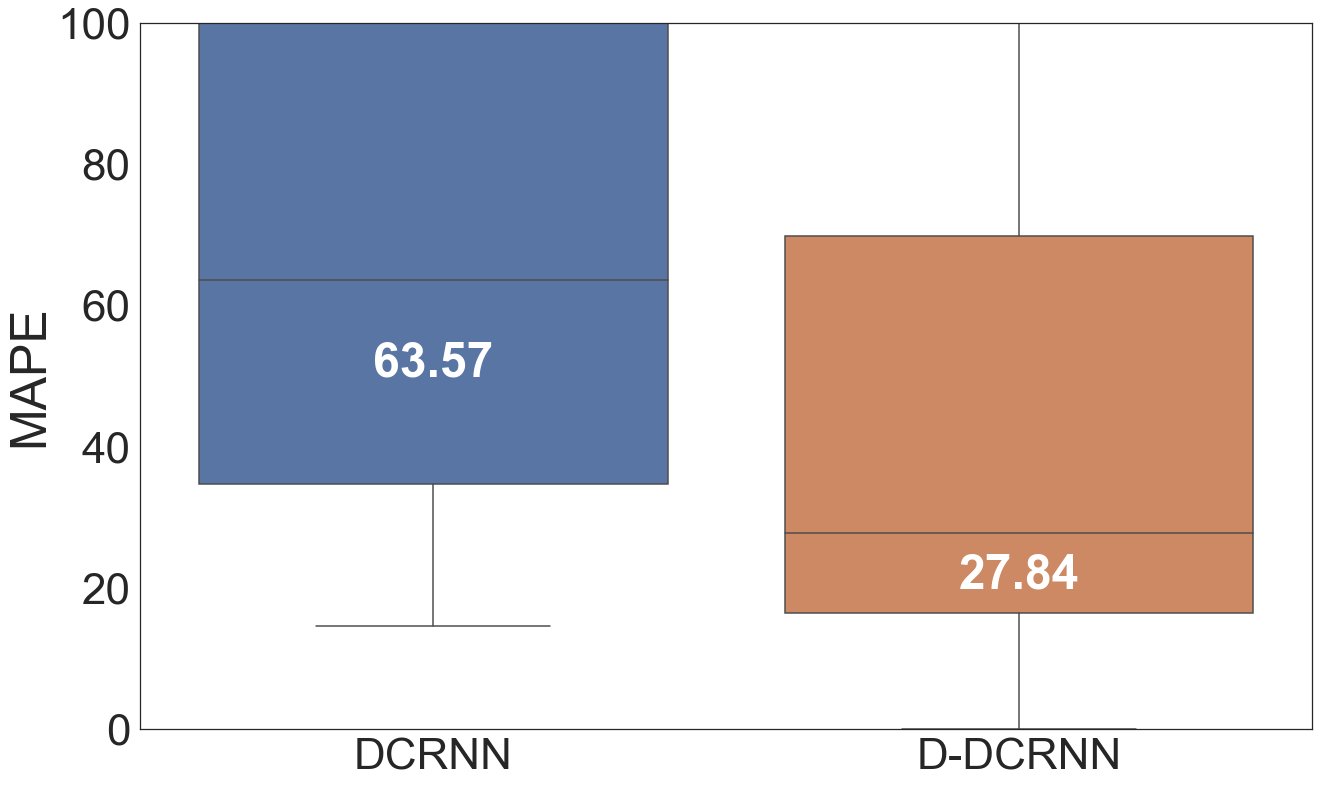

In [9]:
df_DCRNN = pd.read_csv('Results/Results_DCRNN_full/MAPE_DCRNN.csv')
df_DDCRNN = pd.read_csv('Results/Results_DDCRNN_30_24_full/MAPE_DCRNN.csv')

df_DDCRNN = df_DDCRNN.set_index('sites')
df_DCRNN = df_DCRNN.set_index('sites')


df_new = pd.DataFrame()

arr = df_DCRNN.iloc[:, 1:25].values.flatten()
#arr[arr > 100] = np.nan
df_new['DCRNN'] = arr


arr = df_DDCRNN.iloc[:, 1:25].values.flatten() 
#arr[arr > 100] = np.nan
df_new['D-DCRNN'] = arr

mL1 = []
mL1.append(np.round(df_new['DCRNN'].median(), decimals=2))
mL1.append(np.round(df_new['D-DCRNN'].median(), decimals=2))

sns.set(rc={'figure.figsize':(21,13)})
sns.set(font_scale = 4, style="white")
testPlot = sns.boxplot(data=df_new)

top = 50 #m1[ind+1]+1
for tick in range(len(mL1)):
    if tick == 1:
        top = 20
    testPlot.text(tick, top, mL1[tick],  horizontalalignment='center',  color='w', weight='semibold')


#testPlot.set_xlabel('Forecasting strategies', fontsize=50)  
testPlot.set_ylabel('MAPE', fontsize=50)  
testPlot.set_ylim(0,100)

plt.savefig('/Users/tanwimallick/Desktop/esnet_plots/dcrnnVSddcrnnfull_MAPE.png')

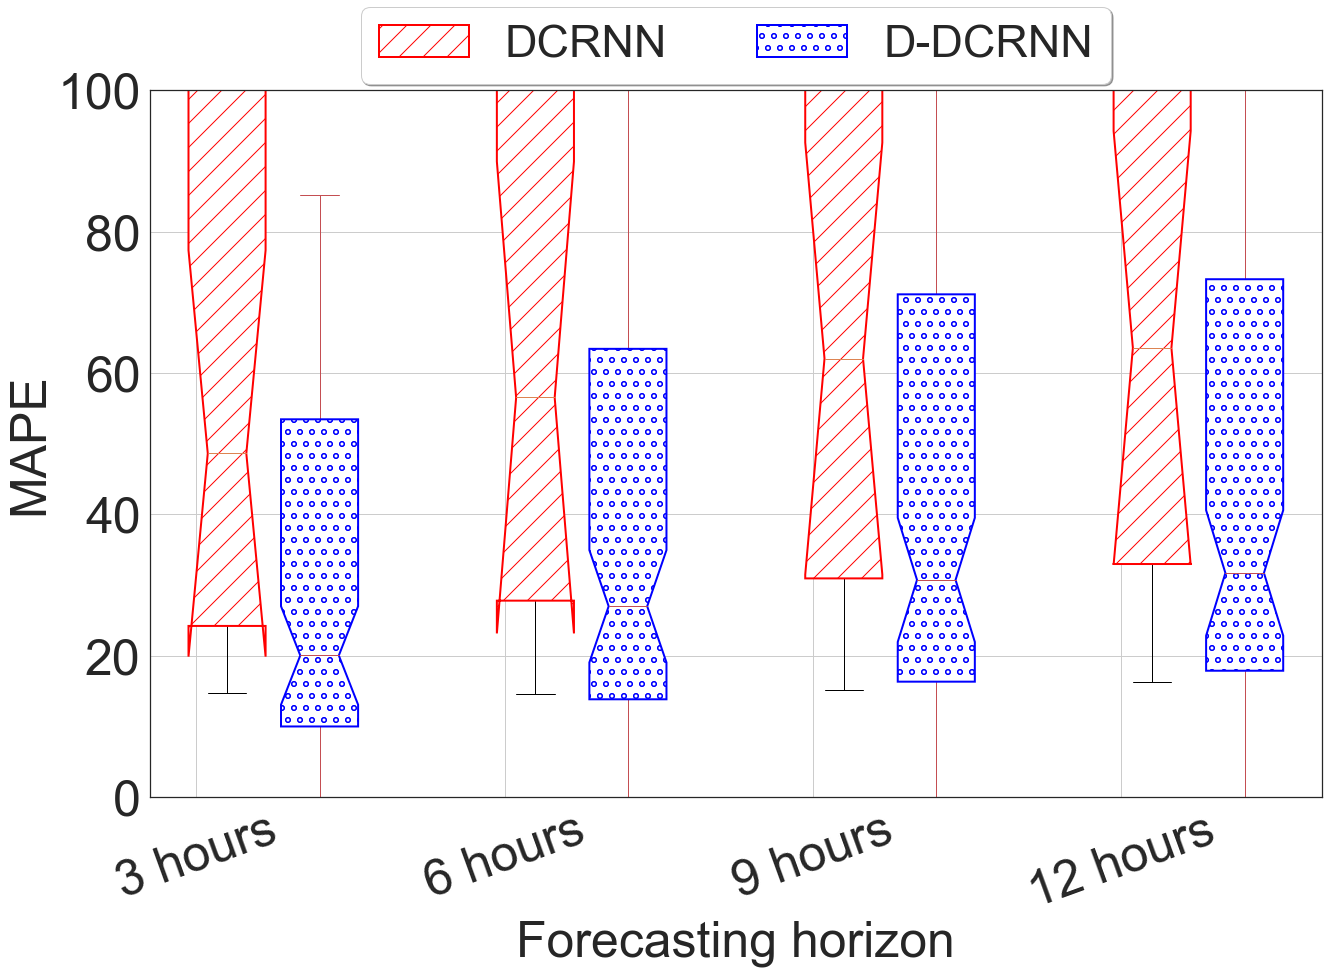

In [11]:
df_DCRNN = pd.read_csv('Results/Results_DCRNN_full/MAPE_DCRNN.csv')
df_DDCRNN = pd.read_csv('Results/Results_DDCRNN_30_24_full/MAPE_DCRNN.csv')

df_DDCRNN = df_DDCRNN.set_index('sites')
df_DCRNN = df_DCRNN.set_index('sites')


df_dc = pd.DataFrame()
df_ddc = pd.DataFrame()

for i in ['3', '6', '9', '12']:
    df_dc[i] = df_DCRNN[i].values.flatten()
    df_ddc[i] = df_DDCRNN[i].values.flatten()

    
    
plt.tick_params(labelsize=30)
plt.tick_params(labelsize=30)
 
l = [1.2, 3.2, 5.2, 7.2] #list(range(1,8, 2))
l2  = [1.8, 3.8, 5.8, 7.8] #list(range(2,11, 2))
c = 'C3'

#plt.figure(figsize=(21, 13), dpi= 80, facecolor='w', edgecolor='k')
bp1 = plt.boxplot(df_dc.values, positions=l, notch=True, patch_artist=True
            )
for box in bp1['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'white' )
    # change hatch
    box.set(hatch = '/')
c2 = "C3"
bp2 = plt.boxplot(df_ddc.values, positions=l2, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c2, color=c2),
            capprops=dict(color=c2),
            whiskerprops=dict(color=c2),
            flierprops=dict(color=c2, markeredgecolor=c2),
            medianprops=dict(color=c2),
            )
for box in bp2['boxes']:
    # change outline color
    box.set(color='blue', linewidth=2)
    # change fill color
    box.set(facecolor = 'white' )
    # change hatch
    box.set(hatch = 'o')
    

ax = plt.gca()
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['DCRNN', 'D-DCRNN'], loc='upper center', 
          fontsize=45, bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

ax.set_ylim([0, 100])   

#plt.ylim((-1, 2)) 
plt.xticks([1, 3, 5, 7],['3 hours','6 hours','9 hours','12 hours'] )



plt.xticks(fontsize=50, rotation=20)
plt.yticks(fontsize=50)


plt.ylabel('MAPE', fontsize=50)  
plt.xlabel('Forecasting horizon', fontsize=50)  
plt.grid(True)

#plt.savefig('/Users/tanwimallick/Desktop/esnet_plots/dcrnnVSddcrnnfull_MAPE.png')